In [49]:
# ============================================================================ #
# 0. Imports & constants                                                       #
# ============================================================================ #
import pathlib
import re
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import layers as L   
from keras import models
from keras.mixed_precision import set_global_policy   
set_global_policy("mixed_float16")        
tf.debugging.set_log_device_placement(True)

DATA_ROOT  = pathlib.Path("../Datasets")   
IMG_SIZE   = (224, 224)
BATCH_SIZE = 16
EPOCHS     = 40
SEED       = 42

In [50]:
# ============================================================================ #
# 1. Build train/test file lists (idx % 5 rule)                                #
# ============================================================================ #
train_files, train_labels = [], []
test_files , test_labels  = [], []

class_names   = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])
class_to_idx  = {c: i for i, c in enumerate(class_names)}
pattern       = re.compile(r"(\d+)\.(jpg|jpeg|png)$", re.IGNORECASE)

for cls in class_names:
    for fp in (DATA_ROOT / cls).iterdir():
        m = pattern.search(fp.name)
        if not m:
            continue                      # skip non-image files
        idx = int(m.group(1))
        target  = test_files  if idx % 5 == 0 else train_files
        labels  = test_labels if idx % 5 == 0 else train_labels
        target.append(str(fp))
        labels.append(class_to_idx[cls])

print(f"Train images: {len(train_files)}, Test images: {len(test_files)}")

Train images: 692, Test images: 170


In [51]:
# ============================================================================ #
# 2. tf.data pipelines                                                         #
# ============================================================================ #
def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def _load(f, y):
        img = tf.io.read_file(f)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0         # scale to [0, 1]
        return img, tf.one_hot(y, len(class_names))

    ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        aug = tf.keras.Sequential([
            L.RandomFlip("horizontal"),
            L.RandomRotation(0.05),
            L.RandomZoom(0.1),
            L.RandomContrast(0.1),
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(1024, seed=SEED)

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_files, train_labels, training=True)
test_ds  = make_ds(test_files , test_labels , training=False)

In [52]:
# ============================================================================ #
# 3. Custom CNN model                                                          #
# ============================================================================ #
def build_cnn(input_shape=(224, 224, 3), n_classes=len(class_names)):
    return models.Sequential([
        # Block 1
        L.Conv2D(32, 3, padding="same", kernel_initializer="he_normal"),
        L.BatchNormalization(),
        L.ReLU(),
        L.Conv2D(32, 3, padding="same", kernel_initializer="he_normal"),
        L.BatchNormalization(),
        L.ReLU(),
        L.MaxPool2D(),
        L.Dropout(0.25),

        # Block 2
        L.Conv2D(64, 3, padding="same", kernel_initializer="he_normal"),
        L.BatchNormalization(),
        L.ReLU(),
        L.Conv2D(64, 3, padding="same", kernel_initializer="he_normal"),
        L.BatchNormalization(),
        L.ReLU(),
        L.MaxPool2D(),
        L.Dropout(0.25),

        # Block 3
        L.Conv2D(128, 3, padding="same", kernel_initializer="he_normal"),
        L.BatchNormalization(),
        L.ReLU(),
        L.Conv2D(128, 3, padding="same", kernel_initializer="he_normal"),
        L.BatchNormalization(),
        L.ReLU(),
        L.MaxPool2D(),
        L.Dropout(0.25),

        # Head
        L.GlobalAveragePooling2D(),
        L.Dense(256, activation="relu"),
        L.Dropout(0.5),
        L.Dense(n_classes, activation="softmax")
    ], name="RiceLeafCNN")

model = build_cnn()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "RiceLeafCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_36 (ReLU)                 │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_37 (ReLU)                 │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_38 (ReLU)                 │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_39 (ReLU)                 │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_40 (ReLU)                 │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_41 (ReLU)                 │ ?                      │             

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [53]:
# ============================================================================ #
# 4. Callbacks                                                                 #
# ============================================================================ #
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=3,
        min_lr=1e-6, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=20, restore_best_weights=True
    )
]

In [54]:
# ============================================================================ #
# 5. Train                                                                     #
# ============================================================================ #
hist = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    callbacks=callbacks
)

Epoch 1/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.3970 - loss: 1.5074 - val_accuracy: 0.1353 - val_loss: 3.8421 - learning_rate: 0.0010
Epoch 2/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5844 - loss: 1.0934 - val_accuracy: 0.4059 - val_loss: 1.4343 - learning_rate: 0.0010
Epoch 3/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6724 - loss: 0.8584 - val_accuracy: 0.3882 - val_loss: 2.5247 - learning_rate: 0.0010
Epoch 4/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6711 - loss: 0.8598 - val_accuracy: 0.4824 - val_loss: 1.5711 - learning_rate: 0.0010
Epoch 5/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6912 - loss: 0.8472 - val_accuracy: 0.6235 - val_loss: 1.0371 - learning_rate: 0.0010
Epoch 6/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6859 - loss: 0.8031 - val_accuracy: 0.6941 - val_loss: 0.8281 - learning_rate: 0.0010
Epoch 7/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7550 - loss: 0.6665 - val_ac

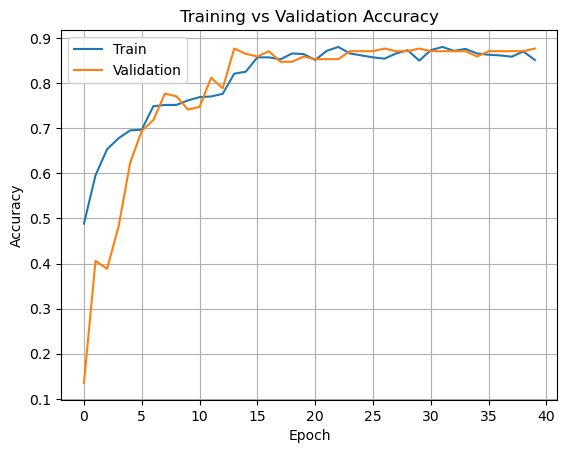

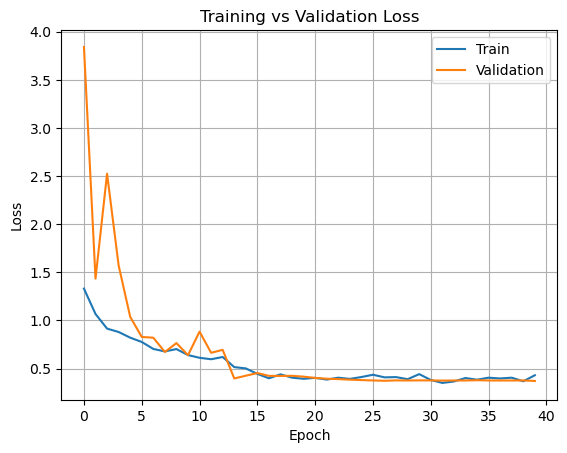

In [55]:
# ============================================================================ #
# 6. Plot accuracy & loss                                                      #
# ============================================================================ #
acc      = hist.history["accuracy"]
val_acc  = hist.history["val_accuracy"]
loss     = hist.history["loss"]
val_loss = hist.history["val_loss"]
epochs   = range(len(acc))

# Accuracy
plt.figure()
plt.plot(epochs, acc,     label="Train")
plt.plot(epochs, val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Loss
plt.figure()
plt.plot(epochs, loss,     label="Train")
plt.plot(epochs, val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()
